# NOTES

# IMPORTS

In [1]:
import os
import cv2
import json
import imutils
import progressbar
import numpy as np
import pandas as pd
from imutils import paths
from keras import layers
from keras import models
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import backend as K
from keras.utils import plot_model
from keras.optimizers import SGD
from keras.callbacks import BaseLogger
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# DATASET

## Preprocessing

In [2]:
class Preprocessor:
    
    def __init__(self, width, height, inter=cv2.INTER_AREA, dataFormat=None):
        self.width = width
        self.height = height
        self.inter = inter
        self.dataFormat = dataFormat
        self.load_widgets = ['Load Data: ', progressbar.Percentage(), ' ', progressbar.Bar(), ' ', progressbar.ETA()]
    
    # path
    def get_images_path(self, img_dir):
        return list(paths.list_images(img_dir))
    
    # data and labels
    def load_data(self, images_path):
        data = []
        labels = []
        
        # start a progress bar
        progress_load = progressbar.ProgressBar(maxval=len(images_path), widgets=self.load_widgets).start()
        
        # loop over the paths
        for (i, path) in enumerate(images_path):
            image = cv2.imread(path)
            image = self.resize(image)
            image = self.img2array(image)
            data.append(image)
            
            # extract labels
            label = path.split('/')[-1].split()[0]
            labels.append(label)
            
            # update progress bar
            progress_load.update(i)
            
        # numpy conversion
        labels = np.array(labels)
        data = np.array(data).astype('float32') / 255.0
        
        progress_load.finish()
        
        return (data, labels)
    
    # resive with aspect ratio
    def resize(self, image):
        # get height, width and initialize crop deltas
        (h, w) = image.shape[:2]
        dH = 0
        dW = 0
        
        
        
        
        # resize
        if w < h:
            image = imutils.resize(image, width=self.width, inter=self.inter)
            dH = int((image_shape[0] - self.height) / 2.0)
        else:
            image = imutils.resize(image, height=self.height, inter=self.inter)
            dW = int((image.shape[1] - self.width) / 2.0)
            
        
        # crop
        (h, w) = image.shape[:2]
        image = image[dH:h - dH, dW:w - dW]
        
        # restore spatial dimension 
        return cv2.resize(image,(self.width, self.height), interpolation=self.inter)
    
    # convert image to keras array
    def img2array(self, image):
        return img_to_array(image, data_format=self.dataFormat)
    

## Load data

In [3]:
preprocessor = Preprocessor(width=200, height=88)
image_dir = 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Datasets/computervision/zindi/working/high/'
images_path = shuffle(preprocessor.get_images_path(image_dir))


In [4]:
(data, labels) = preprocessor.load_data(images_path)

Load Data: 100% |###############################################| Time: 0:00:32


In [5]:
data.shape

(5103, 88, 200, 3)

In [6]:
# data = data.reshape(data.shape[0], data.shape[2], data.shape[1], data.shape[3])

In [7]:
# cv2.imshow('reshaped', data[0])
# cv2.waitKey(0)

In [8]:
labels[:5]

array(['Tillering', 'Heading', 'Booting', 'MidVegetativePhase',
       'CrownRoot'], dtype='<U18')

In [9]:
count = 0
for (i, label) in enumerate(labels):
    if label == 'MidVegetativePhase':
        count += 1
count

689

## Binarization

In [10]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
classNames = lb.classes_

In [11]:
df = pd.DataFrame(labels, columns=[classNames])
df.describe(include='all')

,Anthesis,Booting,CrownRoot,Heading,MidVegetativePhase,Milking,Tillering
count,5103.000000,5103.000000,5103.000000,5103.000000,5103.000000,5103.000000,5103.000000
mean,0.082500,0.116010,0.151088,0.164805,0.135019,0.169312,0.181266
std,0.275153,0.320269,0.358169,0.371041,0.341777,0.375064,0.385276
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Splitting

In [12]:
(trainX, test_x, trainY, test_y) = train_test_split(data, labels, test_size=0.5)
(validationX, testX, validationY, testY) = train_test_split(test_x, test_y, test_size=0.5)

# NETWORK

## Variables

In [13]:
pool_size = (2, 2)
kernel_size = (3, 3)
width = 88
height = 200
depth = 3
classes = 7

input_shape = (width, height, depth)
chann_dim = -1

# configure input shape
if K.image_data_format() == 'channels_first':
    input_shape = (depth, width, height)
    chann_dim = 1


## Net

In [15]:
model = models.Sequential()

model.add(layers.Conv2D(32, kernel_size, padding='same', input_shape=input_shape, activation='relu'))
# model.add(layers.BatchNormalization(axis=chann_dim))
model.add(layers.Conv2D(64, kernel_size, padding='same', activation='relu'))
# model.add(layers.BatchNormalization(axis=chann_dim))
model.add(layers.MaxPooling2D(pool_size=pool_size))
# model.add(layers.Dropout(0.25))

# model.add(layers.Conv2D(64, kernel_size, padding='same', activation='relu'))
# model.add(layers.BatchNormalization(axis=chann_dim))
model.add(layers.Conv2D(128, kernel_size, padding='same', activation='relu'))
# model.add(layers.BatchNormalization(axis=chann_dim))

model.add(layers.Conv2D(256, kernel_size, padding='same', activation='relu'))
# model.add(layers.BatchNormalization(axis=chann_dim))
model.add(layers.MaxPooling2D(pool_size=pool_size))
# model.add(layers.Dropout(0.25))

# model.add(layers.Conv2D(256, kernel_size, padding='same', activation='relu'))
# model.add(layers.BatchNormalization(axis=chann_dim))
# model.add(layers.Conv2D(128, kernel_size, padding='same', activation='relu'))
# model.add(layers.BatchNormalization(axis=chann_dim))
# model.add(layers.Conv2D(512, kernel_size, padding='same', activation='relu'))
# model.add(layers.BatchNormalization(axis=chann_dim))
# model.add(layers.Conv2D(256, kernel_size, padding='same', activation='relu'))
# model.add(layers.BatchNormalization(axis=chann_dim))
# model.add(layers.MaxPooling2D(pool_size=pool_size))
# model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.5))

# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dropout(0.5))

model.add(layers.Dense(classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 88, 200, 32)       896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 88, 200, 64)       18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 44, 100, 64)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 44, 100, 128)      73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 44, 100, 256)      295168    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 50, 256)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 281600)           

## Architecture

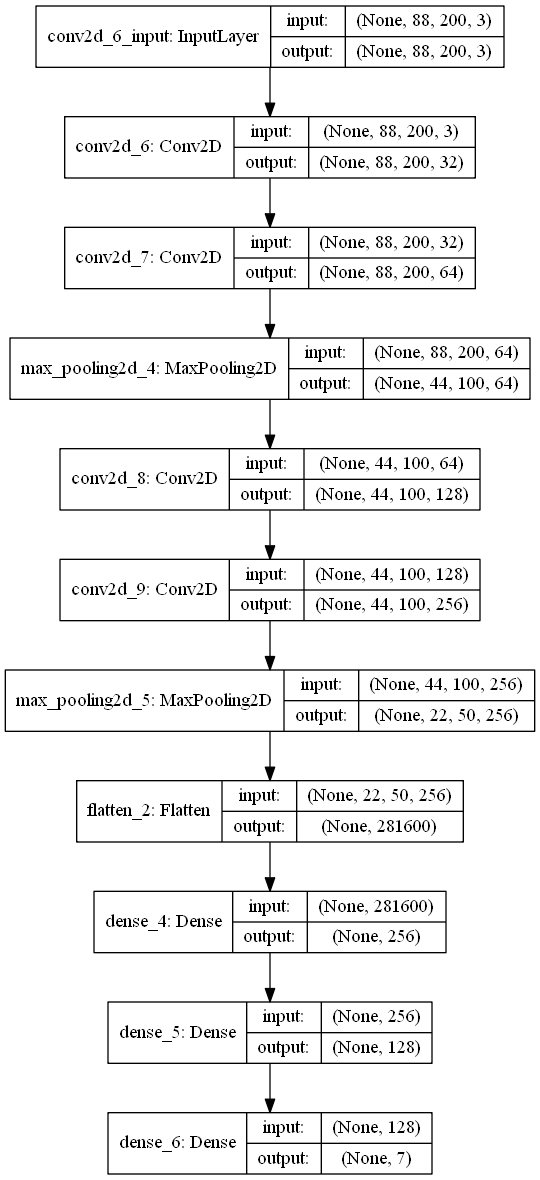

In [16]:
plot_model(model, to_file='serialized/architecture/architecture.png', show_shapes=True)

# COMPILATION

## Optimization

In [18]:
learning_rate = 0.01
epch = 100
opt = SGD(lr=learning_rate, momentum=0.999, decay=learning_rate/epch, nesterov=True)

## Compile

In [19]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

# TRAINING

## Class imbalance problem

In [20]:
# class imbalance problem can be solved by looking at the class weights which define how many of class A go in ration with 
# how many of class B. see the implementation below
classTotal = labels.sum(axis=0)
classWeights = classTotal.max() / classTotal
classWeights

array([2.19714964, 1.5625    , 1.1997406 , 1.09988109, 1.3425254 ,
       1.07060185, 1.        ])

## Data augmentation

In [21]:
aug = ImageDataGenerator(rotation_range=30,width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

## Monitor training

In [23]:
class TrainingMonitor(BaseLogger):
    def __init__(self, figpath, jsonpath=None, startat=0):
        
        super(TrainingMonitor, self).__init__()
        self.figpath = figpath
        self.jsonpath = jsonpath
        self.starat = startat
    
    def on_train_begin(self, logs={}):
        self.history_dict = {}
        
#         # if json history exists, load the training history
#         if self.jsonpath is not None:
#             if os.path.exists(self.jsonpath):
#                 self.history_dict = json.loads(open(self.jsonpath).read())
                
#                 # check if a starting epoch was supplied
#                 if self.startat > 0:
#                     # loop over the entries in the history log and trim any entries that are past the starting epoch
#                     for k in self.history_dict.keys():
#                         self.history_dict[k] = self.history_dict[k][:self.startat]
    
    def on_epoch_end(self, epoch, logs={}):
        # loop over the log and update the loss and acc for the entire traininig process
        for (k, v) in logs.items():
            l = self.history_dict.get(k, [])
            l.append(v)
            self.history_dict[k] = l
        
        # check to see if the training history should be serialized to file
#         if self.jsonpath is not None:
#             f = open(self.jsonpath, 'w')
#             f.write(json.dumps(self.history_dict))
#             f.close()
        
        # ensure at least two epochs have passed befor start plotting
        if len(self.history_dict['acc']) > 1:
            N = np.arange(0, len(self.history_dict['acc']))
            plt.style.use('ggplot')
            plt.plot(N, self.history_dict['acc'], label='Train Accuracy')
            plt.plot(N, self.history_dict['val_acc'], label='Validation Accuracy')            
            plt.plot(N, self.history_dict['loss'], label='Train Loss')            
            plt.plot(N, self.history_dict['val_loss'], label='Validation Loss')
            plt.title('Training loss and accuracy [Epoch {}]'.format(len(self.history_dict['acc'])))
            plt.xlabel('Epoch')
            plt.ylabel('Acc/Loss')
            plt.legend()
            plt.savefig(self.figpath)
            plt.close()

## Callbacks

In [24]:
figpath = 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Computer Vision/imagelab/nn/conv/VGGNET Family/Wheat/serialized/training/plots/'
jsonpath = 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Computer Vision/imagelab/nn/conv/VGGNET Family/Wheat/serialized/training/json/{}.json'.format(os.getpid())

callbacks = [TrainingMonitor(figpath, jsonpath)]

## Train

In [25]:
history = model.fit_generator(aug.flow(trainX, trainY, batch_size=32), callbacks=callbacks, validation_data=(validationX, validationY), epochs=40, steps_per_epoch=len(trainX) // 32)
# history = model.fit(trainX, trainY, class_weight=classWeights, callbacks=callbacks, epochs=100, batch_size=32, validation_data=(validationX, validationY))

Train on 2551 samples, validate on 1276 samples
Epoch 1/100
2551/2551 [==============================] - 83s 32ms/step - loss: 1.8462 - acc: 0.2575 - val_loss: 1.8392 - val_acc: 0.2257
Epoch 2/100
2551/2551 [==============================] - 67s 26ms/step - loss: 1.8218 - acc: 0.2728 - val_loss: 1.8728 - val_acc: 0.1873
Epoch 3/100
2551/2551 [==============================] - 69s 27ms/step - loss: 1.8143 - acc: 0.2458 - val_loss: 1.8951 - val_acc: 0.2586
Epoch 4/100
2551/2551 [==============================] - 66s 26ms/step - loss: 1.8025 - acc: 0.2497 - val_loss: 1.7876 - val_acc: 0.2422
Epoch 5/100
2551/2551 [==============================] - 65s 25ms/step - loss: 1.8369 - acc: 0.2626 - val_loss: 1.8856 - val_acc: 0.2045
Epoch 6/100
2551/2551 [==============================] - 65s 26ms/step - loss: 1.9006 - acc: 0.2058 - val_loss: 1.9073 - val_acc: 0.2147
Epoch 7/100
2551/2551 [==============================] - 69s 27ms/step - loss: 1.9731 - acc: 0.1807 - val_loss: 1.8728 - val_acc: 

KeyboardInterrupt: 

# PLOTTING

In [ ]:
history_dict = history.history
epochs = np.arange(1, len(history_dict['acc']) + 1)

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.style.use('ggplot')

In [ ]:
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Train History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()

# EVALUATION

In [ ]:
result = model.evaluate(testX, testY)

In [ ]:
result

# PREDICTION

# SUMMARY